!wget --no-check-certificate https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F

batch_size= 64
block_size = 128
max_iters = 8000
eval_interval = 200
learning_rate = 1e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 384
n_head = 8
n_layer = 6
dropout = 0.2

torch.manual_seed(1337)

with open ('input.txt', 'r', encoding='utf-8') as f:
  text = f.read()

chars = sorted(list(set(text)))
vocab_size = len(chars) #unique charachters in the text

stoi = { ch:i for i,ch in enumerate(chars) } #can use sentencepiece here as well (or any other subword tokenizer)
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])

data = torch.tensor(encode(text), dtype=torch.long) #making all the data into a pytorch tensor
n = int(0.9*len(data))
train_data = data[:n] #train
val_data = data[n:] #validation

def get_batch(split):
  data = train_data if split == 'train' else val_data
  ix = torch.randint(len(data)-block_size, (batch_size,))
  x = torch.stack([data[i:i+block_size]for i in ix])
  y = torch.stack([data[i+1:i+block_size+1]for i in ix])
  x,y = x.to(device), y.to(device)
  return x,y

@torch.no_grad()
def estimate_loss():
  out = {}
  model.eval()
  for split in ['train', 'val']:
    losses = torch.zeros(eval_iters)
    for k in range(eval_iters):
      X,Y = get_batch(split)
      logits, loss = model(X,Y)
      losses[k] = loss.item()
    out[split] = losses.mean()
  model.train()
  return out

class Head(nn.Module):
  def __init__(self,head_size):
    super().__init__()
    self.key  = nn.Linear(n_embd, head_size, bias=False) #each token describes itself
    self.query  = nn.Linear(n_embd, head_size, bias=False) #each token looks for specific tokens
    self.value  = nn.Linear(n_embd, head_size, bias=False) #transforms the input
    self.register_buffer('tril',torch.tril(torch.ones(block_size, block_size)))
    self.dropout = nn.Dropout(dropout)
  
  def forward(self, x):
    B,T,C = x.shape
    k = self.key(x)
    q = self.query(x)
    wei = q @ k.transpose(-2,-1) * C**-0.5 #scaled multiplication of all quries with all keys (attention)
    wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) #(B,T,T), masking the future tokens
    wei = F.softmax(wei, dim=-1)
    wei = self.dropout(wei)
    v = self.value(x)
    out = wei @ v
    return out


class MultiHeadAttention(nn.Module):
  def __init__(self, num_heads, head_size):
    super().__init__()
    self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
    self.proj = nn.Linear(n_embd, n_embd)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    out = torch.cat([h(x) for h in self.heads], dim =-1)
    out = self.dropout(self.proj(out))
    return out

class FeedForward(nn.Module):
  """One head of self attention"""
  def __init__(self, n_embd):
    super().__init__()
    self.net = nn.Sequential(nn.Linear(n_embd, 4*n_embd), nn.ReLU(), nn.Linear(4*n_embd, n_embd), nn.Dropout(dropout))

  def forward(self,x):
    return self.net(x)

class Block(nn.Module):
  """Transformer block"""
  def __init__(self, n_embed, n_head):
    super().__init__()
    head_size = n_embed//n_head
    self.sa = MultiHeadAttention(n_head, head_size)
    self.ffwd = FeedForward(n_embed)
    self.ln1 = nn.LayerNorm(n_embed)
    self.ln2 = nn.LayerNorm(n_embed)

  def forward(self, x):
    x = x + self.sa(self.ln1(x))
    x = x + self.ffwd(self.ln2(x))
    return x

class BigramLannguageModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.token_embedding_table = nn.Embedding(vocab_size, n_embd) # a table for looking up the next possible token
    self.position_embedding_table = nn.Embedding(block_size, n_embd)
    self.blocks = nn.Sequential(Block(n_embd,n_head=4),Block(n_embd,n_head=4),Block(n_embd,n_head=4), nn.LayerNorm(n_embd))
    self.blocks = nn.Sequential(*[Block(n_embd, n_head= n_head) for _ in range(n_layer)])
    self.ln_f = nn.LayerNorm(n_embd)
    self.lm_head = nn.Linear(n_embd, vocab_size)

  def forward(self, idx, targets = None):
    B, T = idx.shape
    tok_embd = self.token_embedding_table(idx) # output is in the format (B,T,C) or (batch_size, block_size, vocab_size)
    pos_embd = self.position_embedding_table(torch.arange(T,device=device)) # (T,C)
    x = tok_embd + pos_embd #(B,T,C)
    x = self.blocks(x)
    x = self.ln_f(x)
    logits = self.lm_head(x) # (B,T, vocab_size)

    if targets is None:
      loss = None
    else:
      B,T,C = logits.shape
      logits = logits.view(B*T, C) # reshaping since the channel is expected to be the second dimension by pytorch's implementation of cross_entropy
      targets = targets.view(B*T)
      loss = F.cross_entropy(logits, targets)
    return logits, loss
  
  def generate(self, idx, max_new_tokens):
    for _ in range(max_new_tokens):
      idx_cond = idx[:, -block_size:]# cropping input
      logits, loss = self(idx_cond) # goes to the forward method
      logits = logits[:, -1, :] #getting the row from the embedding table of the last charachter in the input sequence
      probs = F.softmax(logits, dim= -1) #making a probability distribution
      idx_next = torch.multinomial(probs, num_samples=1) #sampling the most likely next charachter from the said distribution
      idx = torch.cat((idx, idx_next), dim = 1) #adding the prediction to the input
    return idx

model = BigramLannguageModel()
m = model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate) #using adam

In [ ]:
train_loss = []
val_loss = []
for iter in range(max_iters):

  if iter%eval_interval == 0:
    losses = estimate_loss()
    train_loss.append(losses['train'])
    val_loss.append(losses['val'])
    print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

  xb, yb = get_batch('train')

  logits, loss = m(xb, yb)
  optimizer.zero_grad(set_to_none=True)
  loss.backward()
  optimizer.step()

step 0: train loss 4.2650, val loss 4.2630
step 200: train loss 2.4654, val loss 2.4829
step 400: train loss 2.3795, val loss 2.4020
step 600: train loss 2.2441, val loss 2.2709
step 800: train loss 2.1002, val loss 2.1405
step 1000: train loss 1.9951, val loss 2.0625
step 1200: train loss 1.9042, val loss 1.9956
step 1400: train loss 1.8324, val loss 1.9505
step 1600: train loss 1.7625, val loss 1.9019
step 1800: train loss 1.7082, val loss 1.8615
step 2000: train loss 1.6656, val loss 1.8362
step 2200: train loss 1.6296, val loss 1.7983
step 2400: train loss 1.5960, val loss 1.7796
step 2600: train loss 1.5626, val loss 1.7563
step 2800: train loss 1.5459, val loss 1.7328
step 3000: train loss 1.5190, val loss 1.7128
step 3200: train loss 1.5015, val loss 1.7020
step 3400: train loss 1.4804, val loss 1.6823
step 3600: train loss 1.4639, val loss 1.6693
step 3800: train loss 1.4489, val loss 1.6569
step 4000: train loss 1.4353, val loss 1.6460
step 4200: train loss 1.4178, val loss 1.

In [ ]:
for i in range(len(val_loss)):
  val_loss[i] = val_loss[i].item()
  train_loss[i] = train_loss[i].item()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
val_loss = np.array(val_loss)
train_loss = np.array(train_loss)
x = np.arange(0,8000, 200)

Text(0.5, 1.0, 'Validation Loss')

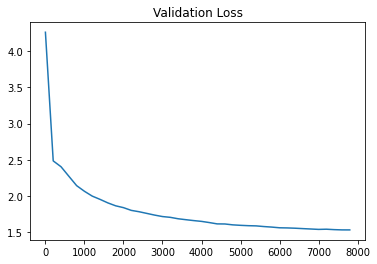

In [ ]:
plt.plot(x, val_loss)
plt.title("Validation Loss")

Text(0.5, 1.0, 'Train Loss')

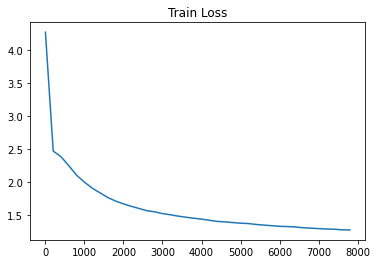

In [ ]:
plt.plot(x, train_loss)
plt.title("Train Loss")

In [ ]:
#step 4500: train loss 1.4966, val loss 1.6931
data = torch.tensor(encode("What is the meaning of life thee daw?"), dtype=torch.long, device = device)
data = data.reshape(1,37)
print(data)
print(decode(m.generate(idx = data, max_new_tokens=500)[0].tolist())) 


tensor([[35, 46, 39, 58,  1, 47, 57,  1, 58, 46, 43,  1, 51, 43, 39, 52, 47, 52,
         45,  1, 53, 44,  1, 50, 47, 44, 43,  1, 58, 46, 43, 43,  1, 42, 39, 61,
         12]], device='cuda:0')
What is the meaning of life thee daw?

RATCLIFF:
Trodise, more are you arribes them.

VOLUMNIA:
A poor queen, and nursuing to way,
And tongue Preter's his father's battle and leap
On mury of ale the lass, that should not,
Don divini. I not striught to me Part Con, I less;
I have med not o' the safeter's profit
Of boy: it well-guest the air must that I see
To have tear while the lightful abon my lands.
Down your pleast, return for us of a wolf,
Then peoplexiness more than that I would this be and
That, an our sworn disposed the king


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
model_save_name = 'transformer_final.pt'
path = f"/content/gdrive/MyDrive/{model_save_name}" 

In [ ]:
torch.save(model.state_dict(), path)